In [207]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from tqdm import tqdm

In [208]:
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First of all, we will define our regressor:

In [209]:
class Regressor(nn.Module):
    def __init__(self, inputs, outputs):
        super(Regressor, self).__init__()
        self.inputs = inputs
        self.outputs = outputs
        
        self.fc1 = nn.Linear(inputs, 8)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(8, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 256)
        self.relu3 = nn.ReLU() 
        self.fc4 = nn.Linear(256, 64)
        self.relu4 = nn.ReLU() 
        self.fc5 = nn.Linear(64, outputs)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        return out
    
    def argforward(self, x, weights):
        x = F.linear(x, weights[0], weights[1])
        x = F.relu(x)
        x = F.linear(x, weights[2], weights[3])
        x = F.relu(x)
        x = F.linear(x, weights[4], weights[5])
        x = F.relu(x)
        x = F.linear(x, weights[6], weights[7])
        x = F.relu(x)
        x = F.linear(x, weights[8], weights[9])
        return x

Now, we will define the functions that creates our artificial dataset. These functions will generate k samples from N different sinusoids. This problem will be known as K-shot regression, using N different tasks.

In [210]:
def generate_data(n_samples, generator, regression=True, noise_scale=2, want_plot = False, **kwargs):

    x_train, y_train = generator(n_samples, **kwargs, train=True) # training data

    if "noise" in kwargs:
        kwargs["noise"] *= noise_scale
    
    x_val, y_val = generator(n_samples, **kwargs, train=True)

    # Plot the data
    if want_plot:
        fig, ax = plt.subplots(1, 2)
        ax[0].set_title("Training Data") 
        ax[1].set_title("Validation Data")

        if regression:
            ax[0].scatter(x_train, y_train, cmap=plt.cm.coolwarm)
            ax[1].scatter(x_val, y_val, cmap=plt.cm.coolwarm)
        else:
            ax[0].scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap=plt.cm.coolwarm)
            ax[1].scatter(x_val[:, 0], x_val[:, 1], c=y_val, cmap=plt.cm.coolwarm)

    return x_train, y_train, x_val, y_val


def generate_sinusoid(n_samples, amp, phase, train=True):
    if train:
        x = np.random.randint(-5., 5., n_samples)
    else:
        x = np.linspace(-5., 5., 200)
    y = amp*np.sin(x-phase)
    
    return x, y


def task_generator(num_tasks, k, want_plot = False):
    amp = np.linspace(0.1, 5., num_tasks)
    phase = np.linspace(0., np.pi, num_tasks)
    tasks = []
    for i in range(num_tasks):
        tasks.append(generate_data(k, generate_sinusoid, amp=amp[i], phase=phase[i], want_plot=want_plot))
    return tasks, {"amp": amp, "phase": phase}

We will make an example using 1000 different tasks, and taking only one sample from each task:

In [211]:
tasks, dat = task_generator(1000, 1)

Let's define the inner loop and the outer loop from the training phase:

In [212]:
def inner_loop(weights, model, x_train, y_train, x_val, y_val, criterion, lr):
    temp_weights = [w.clone() for w in weights]
    x_train = x_train.reshape((x_train.shape[0], 1))
    y_train = y_train.reshape((y_train.shape[0], 1))
    x_val = x_val.reshape((x_val.shape[0], 1))
    y_val = y_val.reshape((y_val.shape[0], 1))
    output = model.argforward(x_train, temp_weights)
    loss = criterion(output, y_train)/5
    grads = torch.autograd.grad(loss, temp_weights)
    temp_weights = [w-lr*g for w, g in zip(temp_weights, grads)]
    output = model.argforward(x_val, temp_weights)
    meta_loss = criterion(output, y_val)/5
    return meta_loss

def outter_loop(weights, tasks, epochs, model, criterion, meta_optimizer, lr):
    total_loss = 0
    for epoch in tqdm(range(epochs)):
        meta_loss_sum = 0
        for i in range(len(tasks)-1):
            x_train = torch.from_numpy(tasks[i][0]).float().to(device)
            y_train = torch.from_numpy(tasks[i][1]).float().to(device)
            x_val = torch.from_numpy(tasks[i][2]).float().to(device)
            y_val = torch.from_numpy(tasks[i][3]).float().to(device)
            
            meta_loss = inner_loop(weights, model, x_train, y_train, x_val, y_val, criterion, lr)
            meta_loss_sum += meta_loss
        meta_grads = torch.autograd.grad(meta_loss_sum, weights)
        
        for w, g in zip(weights, meta_grads):
            w.grad = g
        meta_optimizer.step()
        total_loss += meta_loss_sum.item()/16
        
    return weights

Finally, let's create our model and train it:

In [213]:
model = Regressor(1, 1).to(device)

In [214]:
epochs = 100
criterion = nn.MSELoss()
inner_lr = 0.001
outter_lr = 0.01
meta_optimizer = torch.optim.Adam(model.parameters(), outter_lr)

weights = outter_loop(list(model.parameters()), tasks, epochs, model, criterion, meta_optimizer, inner_lr)



100%|█████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/it]


To check the effectiveness of the model, we define two functions that will train and test our model in a new task. We'll be able to compare the effectiveness of the model in when it's trained in a different number of epochs.

In [215]:
def train(model, x_train, y_train, x_val, y_val, epochs, criterion, optimizer, learning_rate):
    losses = {"train": [], "val": []} # Two lists to keep track of the evolution of our losses

    for t in range(epochs):
        
        # activate training mode
        model.train()
        
        # Feed forward to get the logits        
        y_pred = model(x_train) # x_train is the whole batch, so we are doing batch gradient descent
        
        
    
        # Compute the loss
        loss = criterion(y_pred.squeeze(), y_train.squeeze())
        
        # zero the gradients before running the backward pass
        optimizer.zero_grad()
        
        # Backward pass to compute the gradient of loss w.r.t our learnable params
        loss.backward()

        # Update params
        optimizer.step()

        # Compute the accuracy.
        losses["train"].append(loss.cpu().detach().numpy())
        
        model.eval()
        with torch.no_grad():
            y_pred = model(x_val)
            val_loss = criterion(y_pred.squeeze(), y_val.squeeze())
            losses["val"].append(val_loss.cpu().detach().numpy())
            
    

def test(model, x_train, y_train, x_val, y_val, dat):
    
    original_weights = model.state_dict()
    
    learning_rate = 0.1
    
    x = np.linspace(-5, 5, 600)
    plt.scatter(x, dat['amp'][-1]*np.sin(x-dat['phase'][-1]), label='Original curve')
    plt.scatter(x_val.cpu().detach().numpy(), y_val.cpu().detach().numpy(), label='Samples provided')
    model.eval()
    new_x = torch.from_numpy(x).float().to(device)
    predicted = model(new_x.reshape((new_x.shape[0], 1))).cpu().detach().numpy()
    plt.plot(x, predicted, label='Result without trainning')
    
    epochs = 1
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    losses = train(model, x_train, y_train, x_val, y_val, epochs, criterion, optimizer, learning_rate)
    
    model.eval()
    predicted = model(new_x.reshape((new_x.shape[0], 1))).cpu().detach().numpy()
    plt.plot(x, predicted, label='Result with 1 trainning step')
    
    model.train()
    model.load_state_dict(original_weights)
    epochs = 5
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    losses = train(model, x_train, y_train, x_val, y_val, epochs, criterion, optimizer, learning_rate)
    
    model.eval()
    predicted = model(new_x.reshape((new_x.shape[0], 1))).cpu().detach().numpy()
    plt.plot(x, predicted, label='Result with 5 trainning step')
    
    model.train()
    model.load_state_dict(original_weights)
    epochs = 15
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    losses = train(model, x_train, y_train, x_val, y_val, epochs, criterion, optimizer, learning_rate)
    
    model.eval()
    predicted = model(new_x.reshape((new_x.shape[0], 1))).cpu().detach().numpy()
    plt.plot(x, predicted, label='Result with 15 trainning step')
    
    model.train()
    model.load_state_dict(original_weights)
    epochs = 30
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    losses = train(model, x_train, y_train, x_val, y_val, epochs, criterion, optimizer, learning_rate)
    
    model.eval()
    predicted = model(new_x.reshape((new_x.shape[0], 1))).cpu().detach().numpy()
    plt.plot(x, predicted, label='Result with 30 trainning step')
    
    plt.legend()

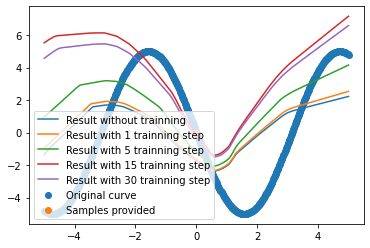

In [216]:
x_train = torch.from_numpy(tasks[-1][0]).float().to(device)
y_train = torch.from_numpy(tasks[-1][1]).float().to(device)
x_val = torch.from_numpy(tasks[-1][2]).float().to(device)
y_val = torch.from_numpy(tasks[-1][3]).float().to(device)

x_train = x_train.reshape((x_train.shape[0], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
x_val = x_val.reshape((x_val.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))

test(model, x_train, y_train, x_val, y_val, dat)

Finally, we can compare the results obtained above with the performance of a regular trained model that faces the same problem as our Meta-Learned model. As we can see, these second model is not able to mimic the behaviour of the sinusoid.

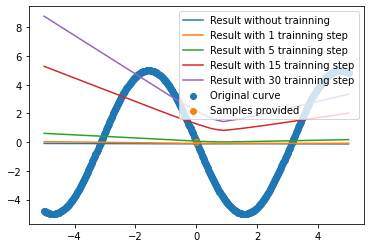

In [217]:
x_train = torch.from_numpy(tasks[-1][0]).float().to(device)
y_train = torch.from_numpy(tasks[-1][1]).float().to(device)
x_val = torch.from_numpy(tasks[-1][2]).float().to(device)
y_val = torch.from_numpy(tasks[-1][3]).float().to(device)

x_train = x_train.reshape((x_train.shape[0], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
x_val = x_val.reshape((x_val.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))

model_regular_trainning = Regressor(1, 1).to(device)
test(model_regular_trainning, x_train, y_train, x_val, y_val, dat)